# Dealing with dates and years

In [105]:
import pandas as pd
from datetime import datetime
import re

df = pd.read_excel("GSAF5.xls")

## Normalize dates

- `Reported` was removed from the date column
- `Sept` is not an accepted `datetime` so it was replaced with `Sep`
- There was a typo in one record `Nox` instead of `Nov`

In [107]:
def normalize_date(date):
    if isinstance(date, datetime): return date
    date = str(date).strip().lower()
    date = date.replace("reported", "")
    date = date.replace("september", "sep")
    date = date.replace("sept", "sep")
    date = date.replace("nox", "nov")
    return date

## Format dates

### Defining regular expressions

- **Short dates:** 30-Oct-2024 or similar
- **Long dates:** 30-October-2024 or similar
- **Years**: 4 consecutive numbers

### Running regular expressions
- If the date is already a Python `datetime` object, return the date as it is
- First match long dates, short dates then years
- Parse these dates into a Python `datetime` object
- If there are any errors, return the date as it is

In [109]:
any = ".*?"
numbers = "[0-9]"
letters = "[a-zA-Z]"
separators = "[-\\s]"

short_date_regex = f"^{any}({numbers}{1,2}){separators}+({letters}{3,4}){separators}+({numbers}{4}){any}$"
long_date_regex = f"^{any}({numbers}{1,2}){separators}+({letters}{4,10}){separators}+({numbers}{4}){any}$"

year_regex = "^[0-9]{4}$"

def match_date(regex, date):
    match = re.search(regex, date)
    if match:
        day = long_match.group(1).zfill(2)
        month = long_match.group(2)
        year = long_match.group(3)
        return datetime.strptime(f"{day}/{month}/{year}", "%d/%B/%Y")
    return None

def format_date(date):
    if isinstance(date, datetime): return date

    try:
        long_date = match_date(long_date_regex, date)
        if long_date: return long_date

        short_date = match_date(short_date_regex, date)
        if short_date: return short_date

        year_match = re.search(year_regex, date)
        if year_match: return None # datetime.strptime(year_match.group(0), "%Y")
    except ValueError: return date

## Normalize years

- For years greater than or equal to 1000, return them as they are
- For dates between 100 and 999 (e.g. 950), add `1` to the beginning (e.g. 1950)
- For dates between 25 and 99 (e.g. 93), add `19` to the beginning (e.g. 1993)
- For dates between 10 and 24 (e.g. 24), add `20` to the beginning (e.g. 2024)
- For dates between 0 and 9 (e.g. 4), add `200` to the beginning (e.g. 2004)

In [111]:
def normalize_year(year):
    if year >= 1000: return year
    if year >= 100: return float(f"1{year}")
    if year >= 25: return float(f"19{year}")
    if year >= 10: return float(f"20{year}")
    if year >= 0: return float(f"200{year}")
    return year

## Infer years from dates

If a year is missing and the date record is present, use the year part from the date column

In [113]:
def infer_year(row):
    if pd.isnull(row.Year): row.Year = row.Date.year
    return row

## Apply functions to DataFrame

1. Normalize date
2. Format date
3. Drop empty dates otherwise
4. Normalize year
5. Infer year

In [115]:
df_copy = df.copy()

df_copy.Date = df_copy.Date.apply(normalize_date)
df_copy.Date = df_copy.Date.apply(format_date)
df_copy = df_copy.dropna(subset="Date")

df_copy.Year = df_copy.Year.apply(normalize_year)
df_copy[["Date", "Year"]] = df_copy[["Date", "Year"]].apply(infer_year, axis=1)

In [117]:
import re

sharks_df = df_copy.copy()

sharks_df['Country'] = sharks_df['Country'].str.split(' / ')

#Explode the Country lists into separate rows
sharks_df = sharks_df.explode('Country')
sharks_df["Country"].unique()
#sharks_df["Country"].nunique()

#replace bad entries with a single country but too repetitive doesn't show true data cleaning
sharks_df['Country'] = sharks_df['Country'].replace({'CEYLON (SRI LANKA)': 'Sri Lanka'})
sharks_df['Country'] = sharks_df['Country'].replace({'ST HELENA, British overseas territory': 'Saint Helena'})



sharks_df["Country"] = sharks_df["Country"].str.lower()
sharks_df = sharks_df.dropna(subset=['Country'])

#sharks_df["Country"] = sharks_df["Country"].replace({"?": ""})
#Call method strip to strip off question marks at the end
sharks_df['Country'] = sharks_df['Country'].str.strip('?')

#call is in method to remove oceans+seas+continents

# Wordslist to remove
words_to_remove = ['Asia', 'Africa' , 'ocean' , 'sea']
mask = ~sharks_df['Country'].isin(words_to_remove)
#df_cleaned = df[mask]

# Display cleaned DataFrame
#print("\nCleaned DataFrame:")
#print(df_cleaned)

def month_grouping(date):
    return date.strftime("%B")

#print(month_grouping(datetime(2024, 1, 1, 0, 0, 0)))
#print(month_grouping(datetime(2024, 2, 1, 0, 0, 0)))
#print(month_grouping(datetime(2024, 3, 1, 0, 0, 0)))

sharks_df["Month"] = sharks_df["Date"].apply(month_grouping)

sharks_df["Time"].unique()

time_df = sharks_df.copy()

any = ".*?"
numbers = "[0-9]"
letters = "[a-zA-Z]"
separators = "[hr\\s\\.]"

#long_time_regex = f"({numbers}{1,2}){separators}*({numbers}{2})"
long_time_regex = "([0-9]{1,2})[hr\\s\\.]*([0-9]{2})"
#short_time_regex = f"({numbers}{1,2})"
short_time_regex = "([0-9]{1,2})[hr\\s\\.]*"

def match_time(regex, time):
    match = re.search(regex, time)
    if match: return match
    return None
    #if match:
    #    hours = match.group(1).zfill(2)
    #    minutes = match.group(2)
    #    return f"{hours}:{minutes}"
    #return None
    
def sanitize_time(time):

    if time in ["Not advised", "Not stated", "?"]: return None
    if not isinstance(time, str): time = str(time)
    
    try:
        long_time = match_time(long_time_regex, time)
        if long_time:
            hours = long_time.group(1).zfill(2)
            minutes = long_time.group(2)
            return f"{hours}:{minutes}"

        short_time = match_time(short_time_regex, time)
        if short_time:
            hours = short_time.group(1).zfill(2)
            return f"{hours}:00"

        return None
    except ValueError: return time

time_df["Time"].unique()
time_df["Time"].apply(sanitize_time).unique()


# add time to Date column

#sharks_df.pivot(index=["Date", "Country", "State"], columns="Type", values="Injury")
# sharks_df.pivot(index["State", "Month"]).count().unstack()
#grouped = sharks_df.groupby(["State", "Country"])["State"].unique().unstack()

#grouped

array([None, '16:00', '11:30', '11:00', '17:35', '11:15', '16:15',
       '13:15', '09:00', '13:00', '14:00', '15:30', '13:30', '09:15',
       '13:40', '12:30', '15:00'], dtype=object)

In [121]:
df_copy.shape

(29, 23)

In [123]:
df_copy.head(10)

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,2024-10-14,2024.0,Unprovoked,Honduras,Tela,Atlantida,Swimming,Roberto Carlose Bu Mejia,M,38,...,Bull shark,Georgienne Bradley: Daily Mail UK: FTN News.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-11,2024.0,Unprovoked,USA,Florida,Brevard County Orlando,Surfing,Teddy Witteman,M,16,...,Bull shark 6ft,Todd SmithFlorida today: News 4:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-09-17,2024.0,Unprovoked,Honduras,Trujillo Colon,Puerto Castillo,Diving for shellfish,Fernando Mendoza Ocampo,M,33,...,Bull shark 6-7ft,Daily Mail UK: The Sun UK: The World Watch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-09-16,2024.0,Unprovoked,Morocco,Southern Morocco,West of Dakhla,Swimming - jumped off yacht,German Tourist,F,30,...,Reportedly a Great White,Andy Currie: Moroccan World News: Sky News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-08-26,2024.0,Unprovoked,Jamaica,Montego Bay,Falmouth,Spearfishing,Jahmari Reid,M,16,...,Reportedly Tiger Shark,Todd Smith: Daily Mail UK: Sky News: People .com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2024-08-06,2024.0,Unprovoked,Belize,Gulf of Honduras,Central America,Swimming - Diving,Annabelle Carlson,F,15,...,Reef shark 6ft (1.8m),Kevin McMurray Tracking Sharks.com New York Po...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2024-07-23,2024.0,Unprovoked,Australia,NSW,"North Shore Beach, Port Macquarie",Surfing,Kai McKenzie,M,23,...,3m White Shark,Nine.com.au: ABC.Net.Au Johannes Marchand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2024-07-18,2024.0,Unprovoked,Australia,Western Australia,Trigg beach Sterling,Surfing,Ryan Lowther,M,41,...,Undetermined small shall shark,Daily Mail: Sky News: The West Australian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2024-07-08,2024.0,Unprovoked,USA,Florida,Ponce de Leon Inlet Volusia County,Diving into Water,Dempsey Manhart,M,14,...,4-5ft Blacktip shark,Miami Herald,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2024-07-05,2024.0,Unprovoked,USA,Florida,New Smyrna Beach,Wading,Not stated,M,26,...,Not specified,Sacbee Fox 35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
df_copy["Date"]

0     2024-10-14
1     2024-10-11
2     2024-09-17
3     2024-09-16
4     2024-08-26
5     2024-08-06
6     2024-07-23
7     2024-07-18
8     2024-07-08
9     2024-07-05
10    2024-07-04
11    2024-07-04
12    2024-07-04
13    2024-07-04
14    2024-07-04
15    2024-06-07
16    2024-06-02
17    2024-06-02
18    2024-05-28
19    2024-05-24
20    2024-05-23
21    2024-05-02
22    2024-04-26
23    2024-04-26
24    2024-04-20
25    2024-04-20
26    2024-04-08
27    2024-04-08
107   2023-05-20
Name: Date, dtype: datetime64[ns]

In [127]:
print(df_copy.nunique())

Date              21
Year               4
Type               2
Country           11
State             21
Location          25
Activity          16
Name              28
Sex                2
Age               21
Injury            28
Unnamed: 11        2
Time              19
Species           21
Source            28
pdf                0
href formula       0
href               0
Case Number        0
Case Number.1      0
original order     0
Unnamed: 21        0
Unnamed: 22        0
dtype: int64


In [129]:
columns_few_unique_values= ["Year", "Type", "Sex"]

In [131]:
for column in columns_few_unique_values: 
    unique_values= df_copy[column].unique()
    print(f"unique values for {column}:")
    print(unique_values)
    print()

unique values for Year:
[2024. 2026. 2025. 2023.]

unique values for Type:
['Unprovoked' 'Provoked']

unique values for Sex:
['M' 'F']



In [133]:
categorical_variables = ["Activity"]

In [135]:
for column in categorical_variables:
    print(df_copy[column].value_counts())

Activity
Swimming                                                           9
Surfing                                                            4
Spearfishing                                                       2
Wading                                                             2
Diving for shellfish                                               1
Swimming - jumped off yacht                                        1
Swimming - Diving                                                  1
Diving into Water                                                  1
Playing football in the water                                      1
Swimming ocean training                                            1
Military ocean training                                            1
snorkelling                                                        1
Freediving                                                         1
Jumpinf from dock to boat acidentally fell into water at marina    1
Fishing                  

In [137]:
print(df_copy["State"].value_counts())

State
Florida                     5
Texas                       3
Nunu Atoll                  2
Western Australia           2
Tela                        1
Galveston                   1
South Australia             1
Clarence Town Long Isand    1
Graet Courland Bay          1
South Carolina              1
Gambier Islands             1
Providenciales Island       1
California                  1
Maahvah Laamu Atoll         1
Floria                      1
NSW                         1
Gulf of Honduras            1
Montego Bay                 1
Southern Morocco            1
Trujillo Colon              1
 Utah                       1
Name: count, dtype: int64


In [139]:
!pip install seaborn

In [141]:
import seaborn as sns

<Axes: xlabel='Sex', ylabel='count'>

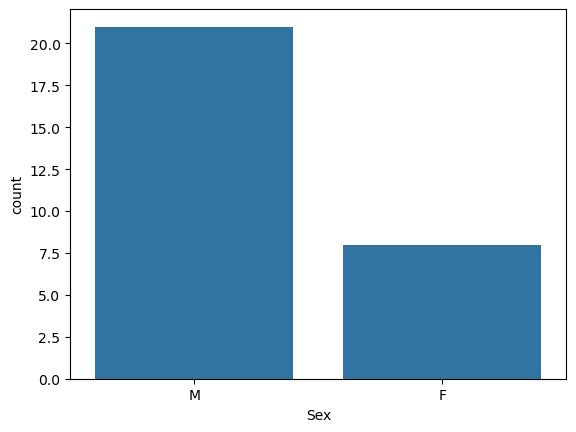

In [143]:
sns.countplot(x='Sex', data=df_copy)

<Axes: xlabel='Year', ylabel='count'>

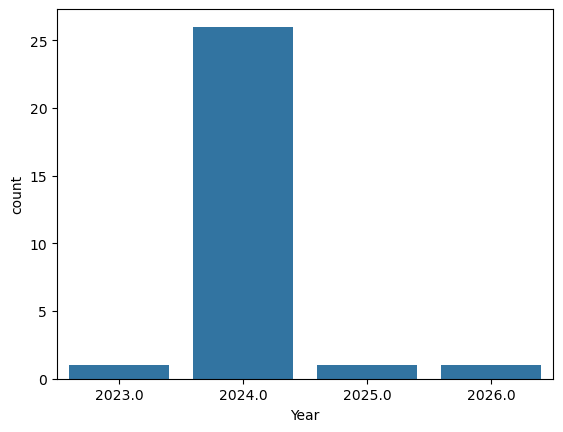

In [145]:
sns.countplot(x='Year', data=df_copy)

<Axes: xlabel='Type', ylabel='count'>

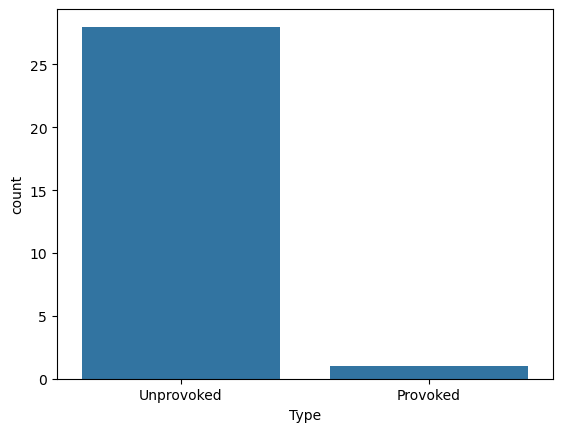

In [147]:
sns.countplot(x='Type', data=df_copy)

<Axes: xlabel='Country', ylabel='count'>

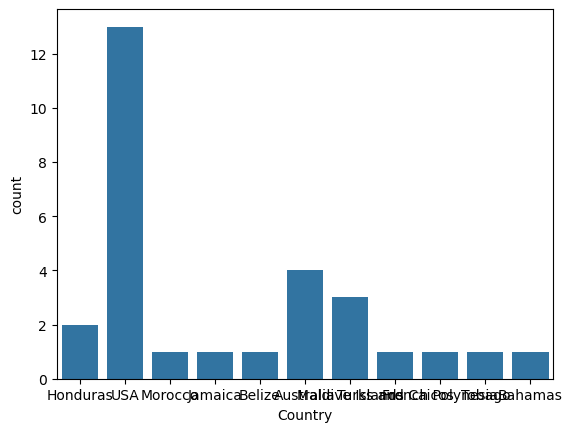

In [149]:
sns.countplot(x='Country', data=df_copy)

<Axes: xlabel='State', ylabel='count'>

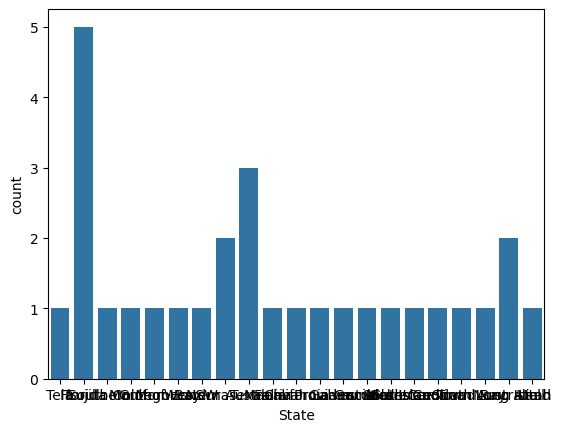

In [151]:
sns.countplot(x='State', data=df_copy)

<Axes: xlabel='Activity', ylabel='count'>

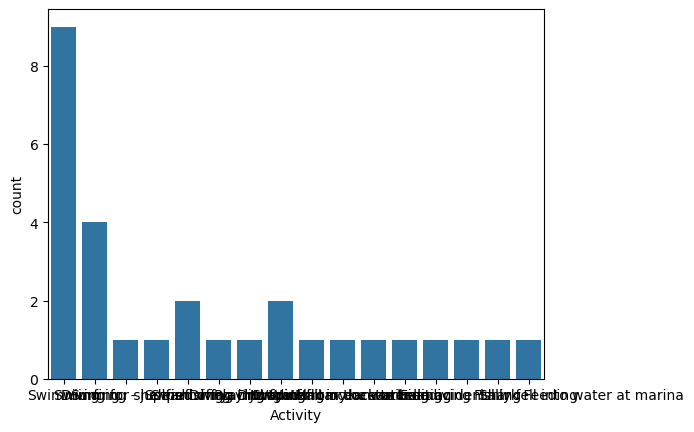

In [153]:
sns.countplot(x='Activity', data=df_copy)

<Axes: xlabel='Age', ylabel='count'>

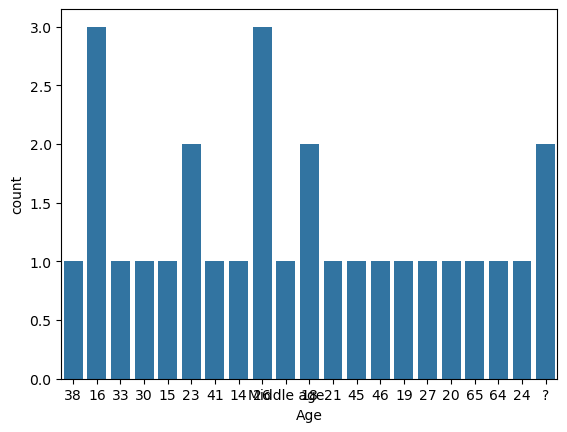

In [155]:
sns.countplot(x='Age', data=df_copy)

In [157]:
print(df_copy["Age"].value_counts())

Age
16            3
26            3
18            2
23            2
?             2
15            1
41            1
14            1
30            1
Middle age    1
33            1
21            1
45            1
46            1
19            1
27            1
20            1
65            1
64            1
24            1
38            1
Name: count, dtype: int64


In [159]:
print(df_copy["Injury"].value_counts())

Injury
Minor injury to left leg                                                          2
Back and thigh extensive tissue loss                                              1
Bite to left arm                                                                  1
Minor injuries left foot                                                          1
Minor bite to left leg                                                            1
Bitten on left leg puncture wounds to kneecap                                     1
Bite wounds to left arm and leg wounds to abdomen and left hand                   1
Bitten on left arm                                                                1
Bite left forearm several ripped tendons severed nerves deep muscle wounds        1
Major damage to right leg later amputated lower left leg left hand and forearm    1
Bitten on left hand by 4-5ft shark                                                1
Wounds to lower extremities Fatal                                    

In [165]:
print(df_copy["Time"].value_counts())

Time
?              7
1100hr         3
Not advised    3
14h            1
12h30          1
13h40          1
9h15           1
13h30          1
Not stated     1
15h30          1
1300           1
1600hr         1
9h             1
13h15          1
16hr15         1
11hr15         1
1735hr         1
11.30hr        1
1500h          1
Name: count, dtype: int64
